In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import shutil

import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import tensorflow as tf

# Import packages for data handling
import h5py
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

# Import deep learning package (tensorflow)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

color = sns.color_palette()
%matplotlib inline


seed_number = 24
np.random.seed(seed_number)
tf.random.set_seed(seed_number)


Configuring directories

In [2]:

root = "../input/lcc-fasd"
input_dir = os.path.join(root,"LCC_FASD")
train_dir = os.path.join(input_dir, 'LCC_FASD_training')
val_dir = os.path.join(input_dir, 'LCC_FASD_development')
test_dir = os.path.join(input_dir, 'LCC_FASD_evaluation')

dataset_dir = [dir for dir in sorted(os.listdir(input_dir)) if os.path.isdir(os.path.join(input_dir, dir))]
label_name = [subdir for subdir in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, subdir))]

# Printing the directory informations
print(f"Main directories\t: {os.listdir(root)}")
print(f"Dataset sub-directories\t: {dataset_dir}")
print(f"Train set directory\t: {label_name}")

Main directories	: ['LCC_FASD']
Dataset sub-directories	: ['LCC_FASD_development', 'LCC_FASD_evaluation', 'LCC_FASD_training']
Train set directory	: ['real', 'spoof']


In [3]:
dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    
    for label in label_name:
        label_list = list(sorted(glob.glob(os.path.join(val, label, "*.png"))))
        if len(label_list) == 0:
          continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        # print(select_img_id)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count

case_count_df = pd.DataFrame(case_count)
img_disp_df = pd.DataFrame(img_disp)
print(f"Dataset summary:\n\n{case_count_df}")

Dataset summary:

       train   val  test
real    1223   405   314
spoof   7076  2543  7266


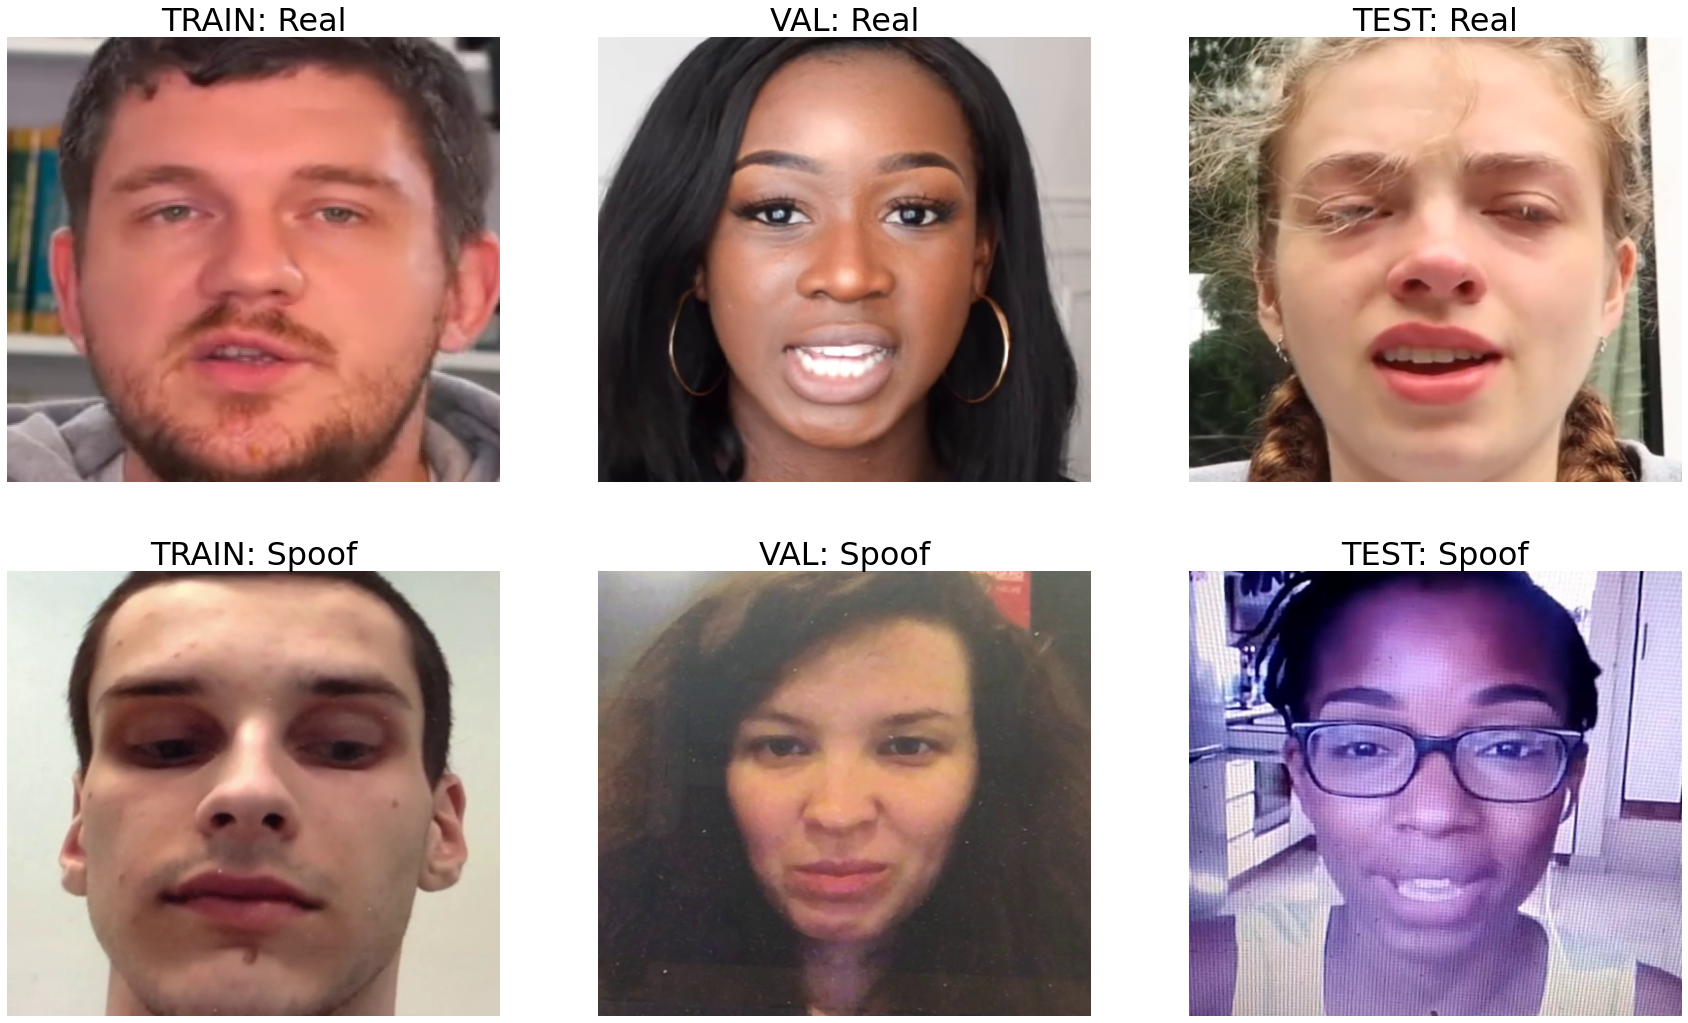

In [4]:

num_classes = len(label_name)
num_dataset = 0
for key, val in set_length.items():
  num_dataset += 1 if val > 0 else 0

f, ax = plt.subplots(num_classes, num_dataset, figsize=(num_dataset*10, 18))

for k in range(num_classes*num_dataset):
    j, i = k//num_dataset, k%num_dataset  # Image indexing
    
    img = imread(img_disp_df.iloc[j, i])
    ax[j, i].imshow(img, cmap='gray')
    ax[j, i].set_title(f"{img_disp_df.columns[i].upper()}: {img_disp_df.index[j].capitalize()}", fontsize=32)
    ax[j, i].axis('off')
    ax[j, i].set_aspect('auto')
plt.show()

# Dataset Problem
Instantiate dataset object for training procedure (e.g., train, val, and test)

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255) if set_length["test"] > 0 else None

In [6]:

train_batch_size = 32
val_batch_size = 32
img_width = 224
img_height = 224


train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size = train_batch_size,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size = val_batch_size,
                                          class_mode = 'binary',
                                          target_size = (img_width, img_height),
                                          seed = seed_number)

if test_datagen is not None:
  test_gen = test_datagen.flow_from_directory(test_dir,
                                              batch_size = 1,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number,
                                              shuffle=False)
else:
  test_gen = None

Found 8299 images belonging to 2 classes.
Found 2948 images belonging to 2 classes.
Found 7580 images belonging to 2 classes.


In [7]:
print(f'Train set batch shape\t: {next(train_gen)[0].shape}')
print(f'Val set batch shape\t: {next(val_gen)[0].shape}')
print(f'Test set batch shape\t: {next(test_gen)[0].shape}') if test_gen is not None else None

Train set batch shape	: (32, 224, 224, 3)
Val set batch shape	: (32, 224, 224, 3)
Test set batch shape	: (1, 224, 224, 3)


# Generate Model
Using a pre-trained MobileNet-v2 model, provided by tensorflow

In [8]:
pretrain_net = mobilenet_v2.MobileNetV2(input_shape = (img_width, img_height, 3),
                                        include_top = False,
                                        weights = 'imagenet')



freeze_before = None 

if freeze_before:
    for layer in pretrain_net.layers:
        if layer.name == freeze_before:
            break
        else:
            layer.trainable = False


9412608/9406464 [==============================] - 1s 0us/step


In [9]:
x = pretrain_net.output
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Dropout(rate=0.2, name='extra_dropout1')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid', name='classifier')(x)

model = Model(inputs=pretrain_net.input, outputs=x, name='mobilenetv2_spoof')
print(model.summary())



Model: "mobilenetv2_spoof"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________

In [10]:
train_id = "lcc-train04b-weight_all"  
num_epochs = 15  
learning_rate = 5e-5  

print(f"Training config of '{train_id}'...")
print(f"Number of epoch\t: {num_epochs}")
print(f"Initial LR\t: {learning_rate}")

model.compile(optimizer = Adam(lr=learning_rate),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

save_dir = os.path.join("./", train_id)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

cont_filepath = "mobilenetv2-epoch_{epoch:02d}.hdf5"
cont_checkpoint = ModelCheckpoint(os.path.join(save_dir, cont_filepath))

best_filepath = "mobilenetv2-best.hdf5"
best_checkpoint = ModelCheckpoint(os.path.join(save_dir, best_filepath),
                                  save_best_only=True,
                                  save_weights_only=True)


log_dir = os.path.join(save_dir, "logs")
use_tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=1,
                              update_freq="batch")


plateau_scheduler = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, 
                                      min_delta= 0.005, min_lr=5e-7)

# Displaying tensorboard
#%tensorboard --logdir log_dir


train_length = len(train_gen.classes)
weight0 = train_length / case_count_df['train'][label_name[0]] * (1 / len(label_name))
weight1 = train_length / case_count_df['train'][label_name[1]] * (1 / len(label_name))
class_weight = {0: weight0, 1: weight1}

print(f"Class weight\t: {class_weight}")


Training config of 'lcc-train04b-weight_all'...
Number of epoch	: 15
Initial LR	: 5e-05
Class weight	: {0: 3.392886345053148, 1: 0.5864188807235726}


Start training!

In [11]:
model.load_weights(r"/kaggle/input/best-weights/mobilenetv2-best.hdf5")


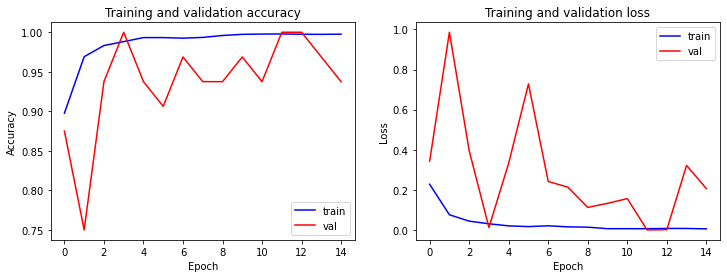

In [13]:

train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))


plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

# Results evaluation
Use this section to evaluate the model performance on the Test set.

In [12]:

test_scores = model.evaluate(test_gen, steps=set_length['test'])
print("Test results Accuracy: {0:.2f}% and Loss: {0:.2f}".format(test_scores[1]*100, test_scores[0]))

threshold = 0.5  
y_pred_value = np.squeeze(model.predict(test_gen, steps=set_length['test'], verbose=1))

y_pred = np.zeros(y_pred_value.shape).astype(np.int32) 
y_pred[y_pred_value > threshold] = 1

 

y_true = test_gen.classes


print(f"Label\t\t: {y_true[:10]}")
print(f"Prediction\t: {y_pred[:10]}")

7580/7580 [==============================] - 148s 19ms/step - loss: 0.0921 - acc: 0.9763
Test results Accuracy: 97.63% and Loss: 97.63
7580/7580 [==============================] - 108s 14ms/step
Label		: [0 0 0 0 0 0 0 0 0 0]
Prediction	: [0 0 0 0 0 1 0 0 0 0]


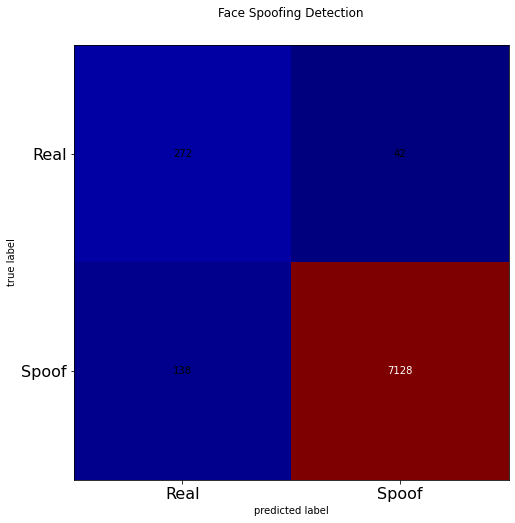

Report Summary:
Precision	: 99.41%
Recall		: 98.10%
F1 Score	: 98.75%

Notes: 
True labels	: Spoof
False labels	: Real


In [13]:

confusion_matrix_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_matrix_result,
                      figsize=(12,8),
                      hide_ticks=True,
                      cmap=plt.cm.jet)
plt.title("Face Spoofing Detection")
plt.xticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.yticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.show()


tn, fp, fn, tp = confusion_matrix_result.ravel()
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)

print("Report Summary:")
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

print("\nNotes: ")
print("True labels\t: Spoof")
print("False labels\t: Real")


In [ ]:
Report Summary:
Precision	: 99.41%
Recall		: 98.10%
F1 Score	: 98.75%

Notes: 
True labels	: Spoof
False labels	: Real

In [14]:
model.save('Desktop.h5')


In [16]:
import shutil


shutil.make_archive('lcc-train04b-weight_all', 'zip', './lcc-train04b-weight_all')


'/kaggle/working/lcc-train04b-weight_all.zip'

In [17]:
from kaggle.api.kaggle_api_extended import KaggleApi


import shutil

shutil.make_archive('lcc-train04b-weight_all', 'zip', './lcc-train04b-weight_all')
files.download('lcc-train04b-weight_all.zip')


OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.